<a href="https://colab.research.google.com/github/beifa/M5_Forecasting/blob/master/lets_try_cv_model_1_ca1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc
import pickle
import random
import numpy as np
import pandas as pd
import lightgbm as lgb

PATH = '/kaggle/input/wmt-inc/'
PATH_PLUS = '/kaggle/input/wmt-plus/'
PATH_WEIGHT = '../input/wmt-weight/' #d --> 1158 - 1914
PATH_MODEL = ''

PATH_D1 = '../input/'
PATH_D2 = '../input/'
PATH_D3 = '../input/'


SEED = 13
random.seed(SEED)
np.random.seed(SEED)


VER = 1

In [ ]:
def read_data(store, start = 0):
    
    remove_features = ['id','state_id','store_id', 'd','sales'] 
    
    encode_f = [
        'enc_dept_id_mean',
        'enc_item_id_mean',   
        'enc_item_id_state_id_mean',      
        'enc_item_id_store_id_mean'   
        ]#best var, 0.47034
    
    ewm = [
        'ewm_lags12_v2',
        #'ewm_lags25_v2'
          ]    
    
    df = pd.concat([
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1),
                pd.read_pickle(PATH_D1)],
                axis =1)
    df= df[df.store_id == store]    
    gc.collect()
    
    
    lags = pd.read_pickle(PATH_D2)
    lags = lags[lags.index.isin(df.index)]
    df = pd.concat([df, lags], axis=1)
    del lags
    gc.collect()
    

    encode = pd.read_pickle(PATH_D3)[encode_f]
    encode = encode[encode.index.isin(df.index)]
    df = pd.concat([df, encode], axis=1)
    del encode
    gc.collect()     


    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d','sales']+features]
    
    #skip row
    df = df[df.d >= start].reset_index(drop=True)
    return df, features

In [ ]:
########## Getting the scales and weights #############
path = '../input/wmt-weight/'

def get_weights_scales_level_12(df, end_test, path):
    """Gets the scale, weight, and scaled weight in a dataframe, 
    aligned with the 'id' column of df. 
    ::path: input path where weight_scale_x files are
    """
    
    # Get the weights and scales for all the levels 
    wdf = pd.read_csv(f'{path}weight_scale_{end_test-27}.csv')
    # Get the sqrt of the scale, because I didn't do 
    # that part in the previous notebook. Then divide the weight by the 
    # sqrt(scale) to get the proper scaled_weight
    wdf['scaled_weight'] = wdf.weight/np.sqrt(wdf.scale)

    # For this function, we just want level 12 weights and scales
    wdf = wdf[wdf.Level_id == 'Level12']

    # We make an 'id' column for easy merging, df must have 'id' column
    wdf['id'] = wdf['Agg_Level_1'] + '_' +  wdf['Agg_Level_2'] + '_evaluation' #'_validation'

    # Taking just he columns we want to use in the merge 
    wdf = wdf[['id', 'scale', 'weight', 'scaled_weight']]

    # Merge with 'id' column of the df
    wdf = pd.merge(df[['id']], wdf, on='id', how='left')
    
    return wdf

def L12_WRMSSE(preds, actuals, p_horizon, num_products, scale, weight): 
    
    actuals = actuals[-(p_horizon * num_products):]
    preds = preds[-(p_horizon * num_products):]
    diff = actuals - preds

    # The first step in calculating the wrmsse is 
    # squareing the daily error.
    res = diff ** 2
    

    # Now divide the result by the appropriate scale
    # take values of scale to avoid converting res 
    # to a pandas series
#     scale = np.concatenate(
#         [scale.values, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], axis = 0)
    #print(len(res), len(scale))
    res = res/scale.values

    # The next step is summing accross the horizon
    # We must reshape our data to get the products
    # in line. 
    res = res
    res = res.reshape(p_horizon, num_products)

    # Now we take the mean accross the prediction horizon
    # and take the square root of the result.
    res = res.mean(axis=0)
    res = np.sqrt(res)

    # Now we multiply each result with the appropriate
    # scaled_weight. We just need the first 30490 entries 
    # of the scaled_weight column
    res = res * weight
    res = res.sum()
    return res


In [ ]:
# for e in [1801, 1829, 1857, 1885]:
#     tr_va_mask = (df['d']>=(e-28)) & (df['d']<(e))
    
#     wdf = get_weights_scales_level_12(df[tr_va_mask], e, PATH_WEIGHT) 
#     scale = wdf.scale
#     print(scale.shape)

In [ ]:
#check correct data
# list_w = [
#     1941,
#     1913,
#     1885,
#     #1858,1830,1802,1774,1746,1718

# ]
# for e in list_w:
#     print(e)
#     train_mask = grid_df['d']<=(e-28)
#     # Test mask, also used here as validation set in lgbm.
#     test_mask = (grid_df['d']>(e-28)) & (grid_df['d']<= (e+28))

#     # Also need a mask for the last 28 days in the training 
#     # set in order for our custom metric to work. 
#     train_valid_mask = (grid_df['d']>=(e-28)) & (grid_df['d']<(e))


#     train_valid = grid_df[train_valid_mask]
#     print(train_valid.shape[0]/28) 
#     print(grid_df[test_mask].shape[0]/28)

In [ ]:
def make_correct_data(df, e):    
    check = (df['d']>=(e-28)) & (df['d']<(e))
    check_df = df[check]
    to_drop = list(check_df['item_id'].value_counts()[check_df['item_id'].value_counts() != 28].index)
    temp_df = df[df['d']<=e].copy()
    temp_df = temp_df[~temp_df.item_id.isin(to_drop)]
    return temp_df

def train(e, df, features,tr_mask, va_mask, store, lgb_params, seed=False, cv = False):
    """
    e - ends perids or fold    
    e is [1885, 1913]    
    """
    scores = []      
    train_data = lgb.Dataset(df[tr_mask][features], 
                            label=df[tr_mask]['sales'])
    
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    val_data = lgb.Dataset(df[va_mask][features], 
                          label=df[va_mask]['sales'])    
   
    print('Start train lgbm')
    if seed:
        print(f'Seed: {seed}')
        lgb_params.update(
            {'seed': seed} 
            )
    estimator = lgb.train(lgb_params,                          
                          train_data,
                          NUM_ITERATIONS,
                          valid_sets = [val_data],
                          verbose_eval = 100,
                          #early_stopping_rounds= 25,
                          #fobj = custom_asymmetric_train_2, 
                          feval = custom_metric  
                          )
    scores = estimator.best_score['valid_0']
    scores['interval'] = e 
    scores['seed'] = seed
    scores['stores'] = store
    scores['iteration'] = estimator.best_iteration
    if cv: scores['param'] = lgb_params
    
    lgb.plot_importance(estimator, figsize=(15,15))
    !rm train_data.bin
    del df, train_data, val_data, estimator
    gc.collect()
    print('Ends')
    return scores
    

Fold: 1, Ends period: 1801
CA_1
Start train lgbm


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	valid_0's rmse: 1.98883	valid_0's L12_WRMSSE: 0.793039
[200]	valid_0's rmse: 1.92021	valid_0's L12_WRMSSE: 0.767029
[300]	valid_0's rmse: 1.91032	valid_0's L12_WRMSSE: 0.763573
[400]	valid_0's rmse: 1.90464	valid_0's L12_WRMSSE: 0.761988
[500]	valid_0's rmse: 1.90225	valid_0's L12_WRMSSE: 0.761514
[600]	valid_0's rmse: 1.89999	valid_0's L12_WRMSSE: 0.760981
[700]	valid_0's rmse: 1.89831	valid_0's L12_WRMSSE: 0.760625
[800]	valid_0's rmse: 1.89691	valid_0's L12_WRMSSE: 0.760475
[900]	valid_0's rmse: 1.89606	valid_0's L12_WRMSSE: 0.760432
[1000]	valid_0's rmse: 1.89512	valid_0's L12_WRMSSE: 0.760115
[1100]	valid_0's rmse: 1.89484	valid_0's L12_WRMSSE: 0.76012
[1200]	valid_0's rmse: 1.89441	valid_0's L12_WRMSSE: 0.760411
[1300]	valid_0's rmse: 1.895	valid_0's L12_WRMSSE: 0.760639
[1400]	valid_0's rmse: 1.89473	valid_0's L12_WRMSSE: 0.760915
Ends
Fold: 2, Ends period: 1829
CA_1
Start train lgbm
[100]	valid_0's rmse: 1.96803	valid_0's L12_WRMSSE: 0.749384
[200]	valid_0's rmse: 1.94189

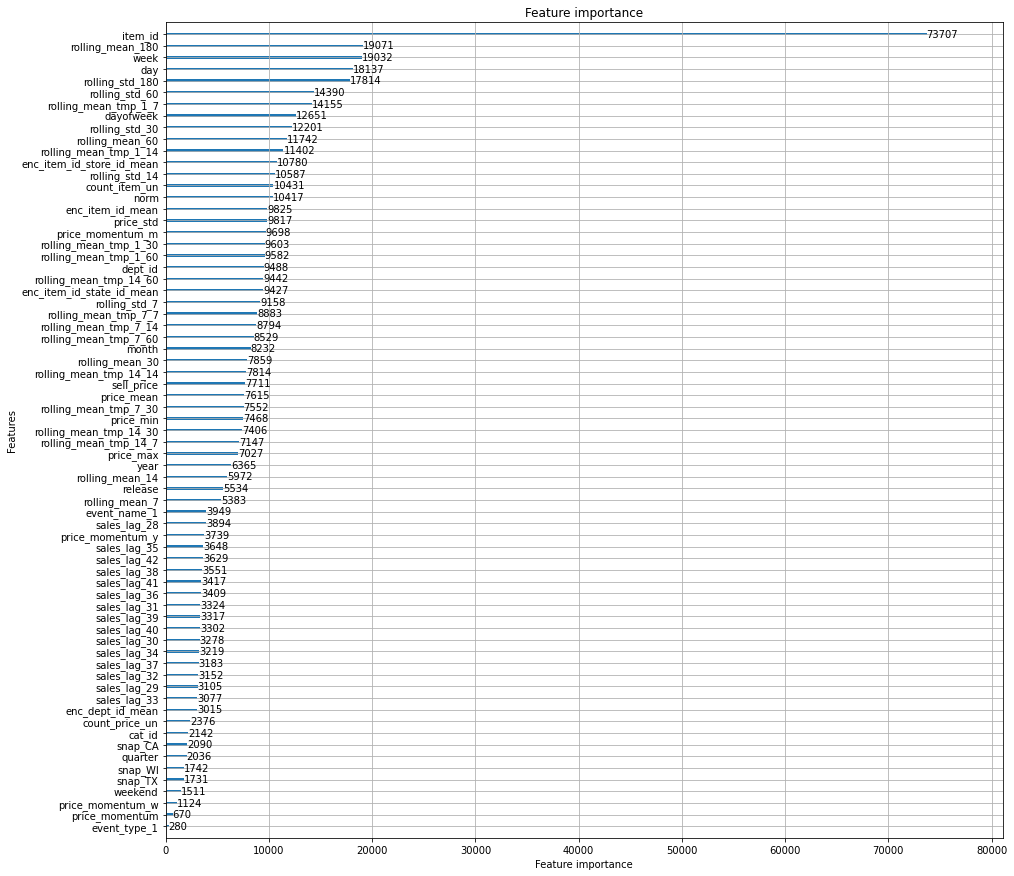

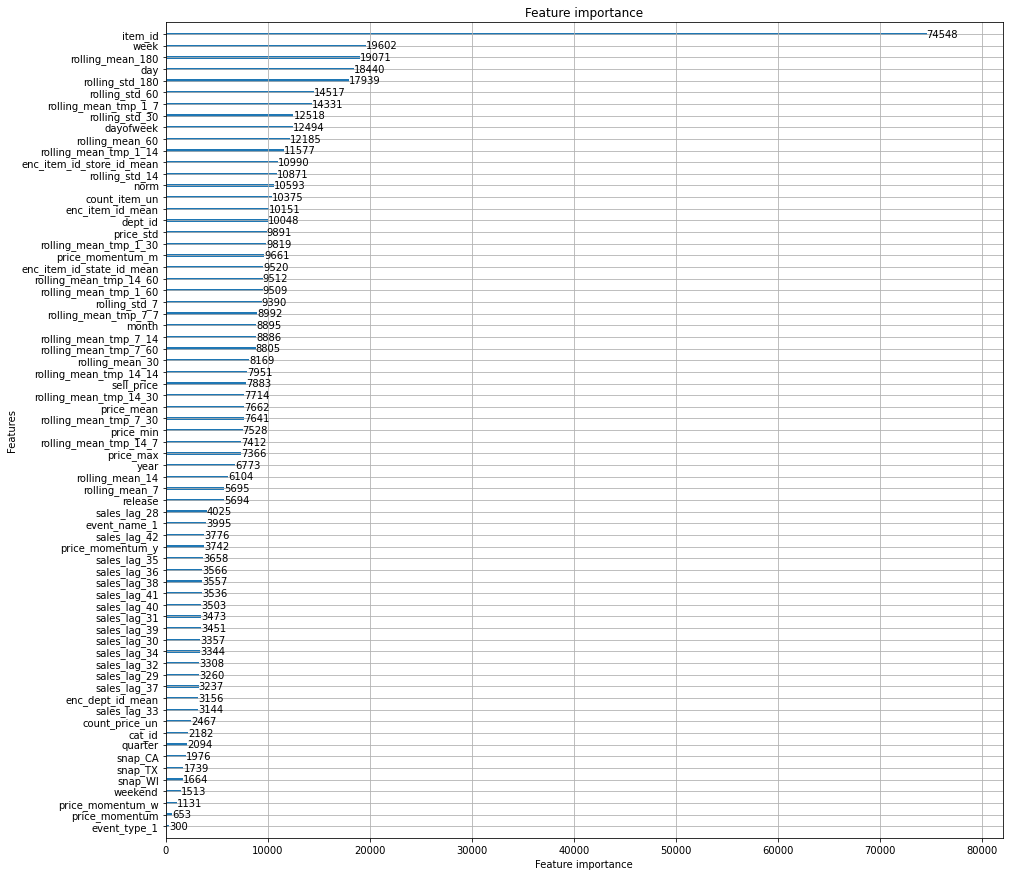

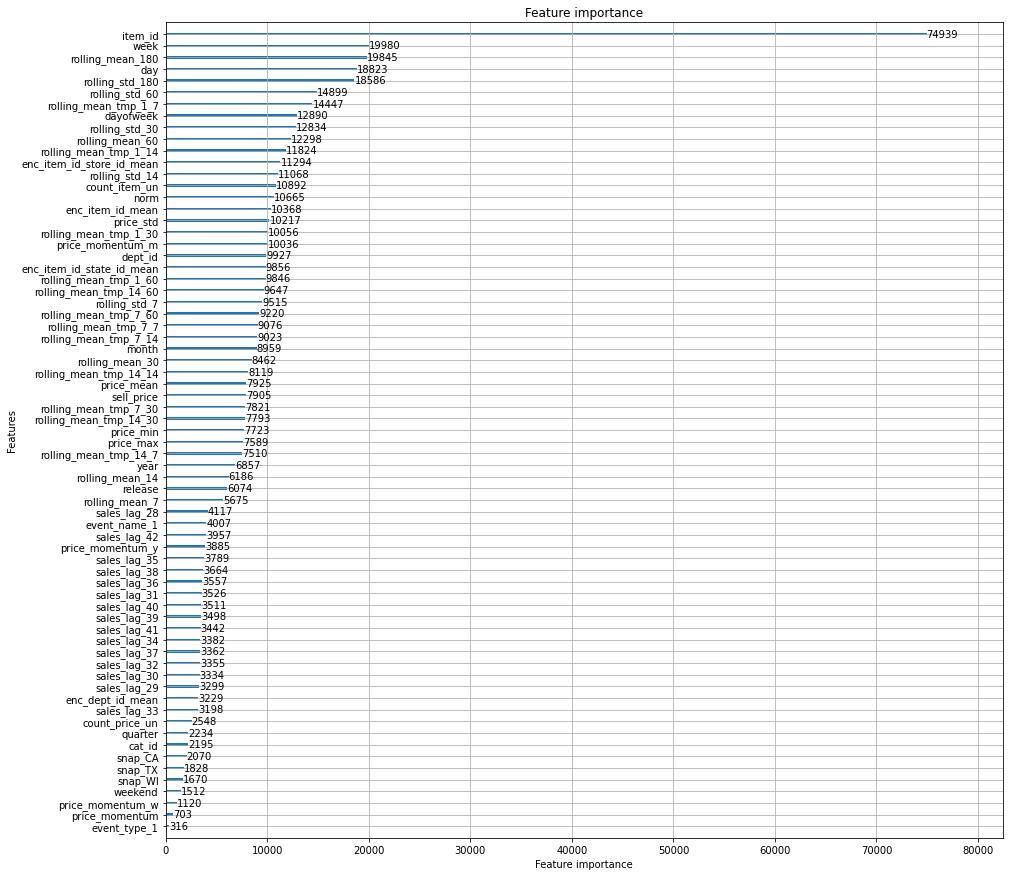

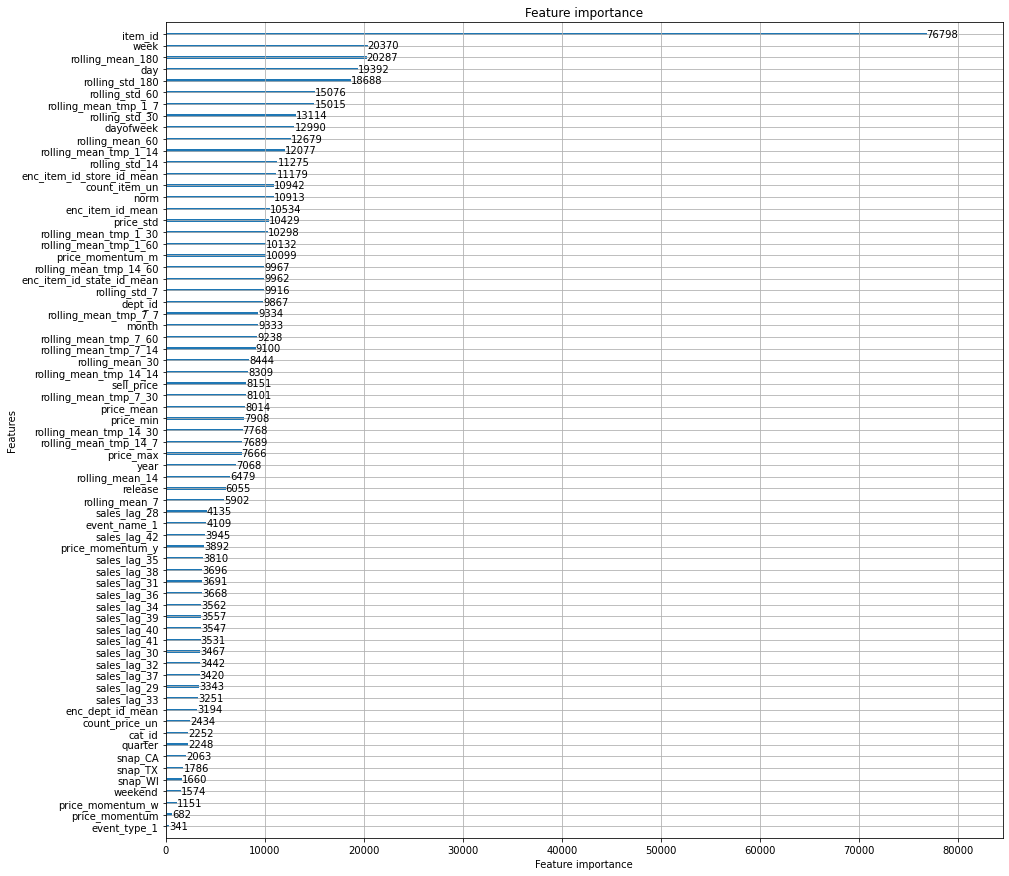

In [ ]:
%%time
NUM_ITERATIONS = 1400
NUM_PRODUCTS = 30490
P_HORIZON = 28


#speed
lgb_params = {
    'boosting_type': 'gbdt',   
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',         
    'bagging_fraction': 0.8,          
    'subsample_freq': 1,
    'learning_rate': 0.05,    
    'num_leaves': 128,      
    'min_data_in_leaf': 256,
    'feature_fraction': 0.8,    
    'verbose': -1
    }


"""
тут только те которые хуже по предикту в районе rmse 2

"""
lgb_params['seed'] = SEED
STORES_IDS = [
    'CA_1',
    'CA_3',
    'WI_2'
]

def custom_metric(preds, train_data):
    actuals = train_data.get_label()
    res = L12_WRMSSE(preds, actuals, 28, NUM_PRODUCTS, scale, weight)
    return 'L12_WRMSSE', res, False

# Custom loss function 
# def WMSSE(preds, train_data):
#     print(preds)
#     labels = train_data.get_label()
#     weight = train_data.get_weight()
#     print(weight)
#     print((preds - labels)**2)
#     loss = weight*((preds - labels)**2)
#     grad = 2 * weight * (preds - labels)
#     hess = 2 * weight
#     return grad, hess

def custom_asymmetric_train_2(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual )
    hess = np.where(residual < 0, 2, 2 )

    return grad, hess

temp = []
#seeds = []
store = 'CA_1'
#for store in STORES_IDS:
df, features = read_data(store, start = 0)
for i, e in enumerate([1801, 1829, 1857, 1885], 1):
    print(f'Fold: {i}, Ends period: {e}')
    #for seed in seeds:
    print(store)
    temp_df = make_correct_data(df, e)
    tr_mask = temp_df['d']<=(e-28)
    va_mask = (temp_df['d']>(e-28)) & (temp_df['d']<= (e+28))
    tr_va_mask = (temp_df['d']>=(e-28)) & (temp_df['d']<(e))

    wdf = get_weights_scales_level_12(temp_df[tr_va_mask], e, PATH_WEIGHT) 
    NUM_PRODUCTS = temp_df.id.nunique()
    scale = wdf.scale
    weight = wdf.weight[:NUM_PRODUCTS]
    weight = weight/weight.sum()
    scores = train(e, temp_df, features, tr_mask, va_mask, store, lgb_params, False, False)
    temp.append(scores)
    del temp_df
    gc.collect()